In [69]:
import numpy as np
from numpy import nan

from verbose.verbose import print_state, print_experience, print_buffer, print_shapes
from verbose.verbose import print_action_available, print_interaction, print_cummulative_reward
from utils.constant import *
from verbose.plot import plot_evolution
from environnement.pre_processing import pre_processing_state, denormalize_vector


from agent.DQN import DQNAgent
from environnement.env import Env
from agent.strategy import EpsilonGreedy


%load_ext autoreload
%autoreload 2


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-06-20 11:45:44.771083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 11:45:44.771372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/widium/.conda/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [70]:
STACK_SIZE = 3
NBR_STACK = 2

env = Env(STACK_SIZE)
strategy = EpsilonGreedy(MIN_EPSILON, START_EPSILON, DECAY)
agent = DQNAgent(STACK_SIZE, NBR_STACK, len(env.action_space()))

In [71]:
print_state(env, shape=True)

---State t---
-A-	-B-
___________	
|729.0	0.0|
|89.0	0.0|
|972.0	0.0|
___________	
A shape : (3, 1)
B shape : (3, 1)
___________	
------------
Env : in progress
------------


Episode : [0]
---State t---
-A-	-B-
___________	
|925.0	0.0|
|422.0	0.0|
|374.0	0.0|
___________	
------------
Env : done
------------
=== Actions available ===
rotate_a
inverse_rotate_a
swap_a
push_b
Exploration
----------------------------------
Action : [push_b]
Reward : [92]
----------------------------------
---State t---
-A-	-B-
___________	
|925.0	0.0|
|422.0	0.0|
|374.0	0.0|
___________	
------------
Env : done
------------
----------------------------------
Cumulative Reward [92]
----------------------------------


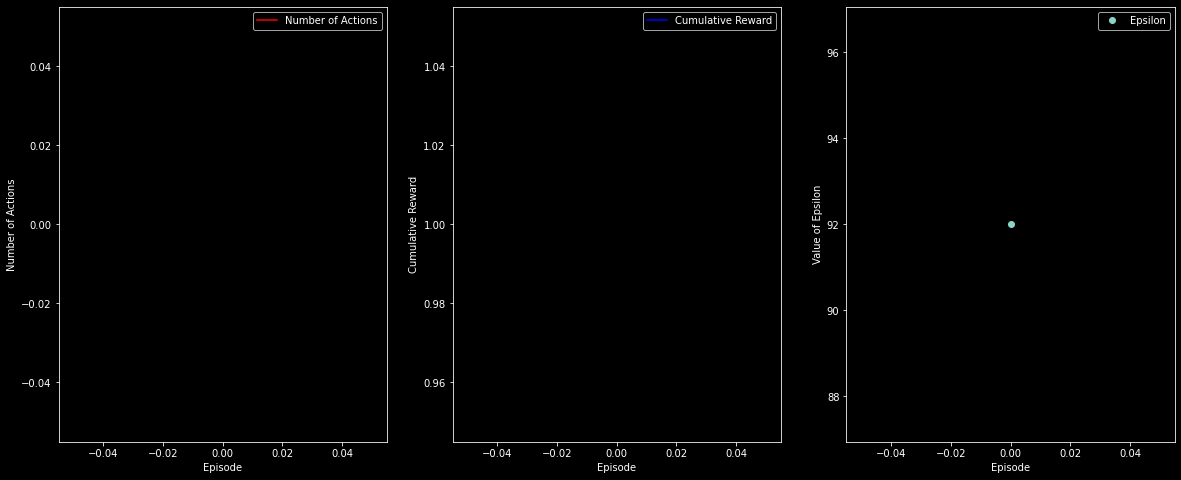

Episode : [1]
---State t---
-A-	-B-
___________	
|26.0	0.0|
|915.0	0.0|
|151.0	0.0|
___________	
------------
Env : in progress
------------
=== Actions available ===
rotate_a
inverse_rotate_a
swap_a
push_b
Exploration
----------------------------------
Action : [push_b]
Reward : [-1]
----------------------------------
---State t---
-A-	-B-
___________	
|915.0	26.0|
|151.0	0.0|
|0.0	0.0|
___________	
------------
Env : in progress
------------
=== Actions available ===
rotate_a
inverse_rotate_a
swap_a
push_b
push_a
Exploration
----------------------------------
Action : [rotate_a]
Reward : [-1]
----------------------------------
---State t---
-A-	-B-
___________	
|151.0	26.0|
|915.0	0.0|
|0.0	0.0|
___________	
------------
Env : in progress
------------
=== Actions available ===
rotate_a
inverse_rotate_a
swap_a
push_b
push_a
Exploration
----------------------------------
Action : [push_a]
Reward : [-1]
----------------------------------
---State t---
-A-	-B-
___________	
|26.0	0.0|
|15

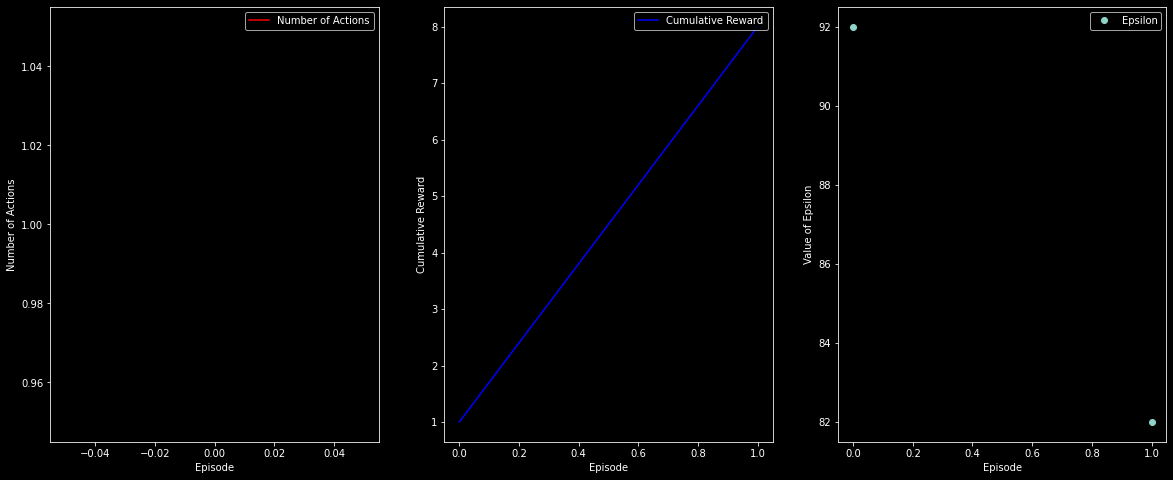

In [72]:
episode_durations = list()
cummulative_reward = list()
epsilon = list()

for episode in range(EPISODE):
    
    print(f"Episode : [{episode}]")
    env.reset(STACK_SIZE)
    
    state = env.get_state()
    # print_state(env, shape=True)
    
    timesteps = 0
    while (1):
        
        # action_available(env)
        print_state(env)
        timesteps += 1
        
        exploration_rate = strategy.get_exploration_rate(timesteps)
        print_action_available(env)
        action = env.choose_action(state, agent.policy_model, exploration_rate)
        reward = env.reward()
        next_state = env.get_state()
        print_interaction(exploration_rate, action, reward)
        
        
        
        experience = env.create_experience(state, action, next_state, reward)
        env.replaymemory.push(experience)
        state = next_state
        
        # print_experience(experience)
        if env.replaymemory.can_provide_sample(BATCH_SIZE):
            print("======== START TRAIN ========")
            
            buffer = env.replaymemory.get_sample(BATCH_SIZE)
            # print_buffer(buffer)
            
            states, actions, next_states, rewards, dones = env.replaymemory.extract_value(buffer)
            # print_shapes(states, next_states)
            agent.train(states, next_states, buffer)
        
        # print(f"Env : {env.state()}")
        if (env.state() == 'done'):
            print_state(env)
            print_cummulative_reward(env)
            epsilon.append(strategy.epsilon)
            episode_durations.append(timesteps)
            cummulative_reward.append(env.cummulative_reward)
            
            plot_evolution(episode, episode_durations, cummulative_reward)
            break
            
    
    

In [73]:
env.replaymemory.print_history(BATCH_SIZE)

Actions : 0 	 Reward : 92
Actions : 0 	 Reward : -1
Actions : 3 	 Reward : -1
Actions : 1 	 Reward : -1
Actions : 7 	 Reward : -1
Actions : 0 	 Reward : -1
Actions : 1 	 Reward : -6
Actions : 3 	 Reward : -1
Actions : 5 	 Reward : 94
